In [219]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from da.l63 import lorenz63
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.po import PO

In [220]:
# params
s = 10
b = 8/3
r = 28

# time step size
dt = 0.01

# obs_per
obs_per = 3

# Dt: 時間刻み
# NOTE: nature runの生成に使ったdtに対して，Dt = dt * obs_perとなるように設定．
Dt = dt * obs_per

p = (s, r, b)
# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, Dt):
    for i in range(int(Dt/dt)):
        x = rk4(lorenz63, 0, x, p, dt)
    return x

# 単位行列
I = np.eye(3, dtype=float)

# 観測
H_diag = np.array([1.0, 0.0, 0.0])
H = np.diag(H_diag)
print("H:", H)

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((3, 3))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r0 = np.sqrt(0.1)
R = r0**2*I

# 観測値と真値
end_step = 12000 # 開発用
x_true = np.load('x_true_l63_full.npy')[:end_step:obs_per]
y = x_true + np.random.normal(loc=0, scale=r0, size=x_true.shape)  # R = r0^2*I

y = y@H.T

# EnKFの初期値
seed = 1
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]
P_0 = 38*I

# inflation
alpha = 5.0

# ensemble size
m = 2

# generate initial ensemble
X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)


H: [[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [221]:
# RUN DA
# we can pass function observation
# def Hn(x):
#     return H@x

po = PO(M, H, R, alpha=alpha, store_ensemble=True, additive_inflation=True, project_cov=True)
po.initialize(X_0)
for y_obs in tqdm(y):
    po.forecast(Dt)
    po.update(y_obs)

x_assim = po.x

100%|██████████| 4000/4000 [00:00<00:00, 6131.30it/s]


RMSE time mean obs: 0.1458242778271029
RMSE time mean PO: 0.32768997884950096


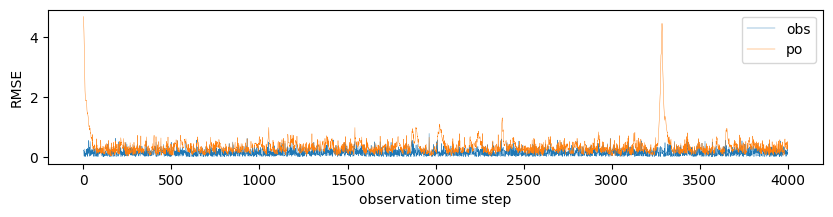

In [222]:
# Plot
fig, ax = plt.subplots(figsize=(10, 2))
ax.set_xlabel("observation time step")
ax.set_ylabel("RMSE")
plot_loss(x_true@H.T, y, loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true, x_assim, loss_rms, ax=ax, label='po', lw=0.3)
ax.legend()
# ax.set_ylim([0, 10])
print("RMSE time mean obs:", loss_rms(x_true@H.T, y)[500:].mean())
print("RMSE time mean PO:", loss_rms(x_true, x_assim)[500:].mean())

## Covariance

In [223]:
from numpy import cov
# forecast ensemble covariance
Xf = np.array(po.Xf)
print(Xf.shape)
P_f = [cov(X.T) for X in Xf]

# analysis ensemble covariance
Xa = np.array(po.Xa)
print(Xa.shape)
P_a = [cov(X.T) for X in Xa]

# forecast - true
E_f = Xf.mean(axis=1) - x_true
print(E_f.shape)
e_f = np.linalg.norm(E_f, axis=1)/(3-1)

# analysis - true
E_a = Xa.mean(axis=1) - x_true
print(E_a.shape)
e_a = np.linalg.norm(E_a, axis=1)/(3-1)

(4000, 2, 3)
(4000, 2, 3)
(4000, 3)
(4000, 3)


In [224]:
# import scipy.linalg as spl

# 以下が成り立って欲しいが固有値分解の自由度のせいで固有ベクトルが一致しない．
# for i in range(len(P_f)):
#     assert np.allclose(spl.eig(P_f[i])[1], spl.eig(P_a[i])[1]), (spl.eig(P_f[i])[1], spl.eig(P_a[i])[1])

# lambda_f -> lambda_a: ETKF updateによる固有値の変化の確認(POではランダム性から成立しない)
# if H.shape == (3, 3) and np.allclose(H, np.eye(3)):
#     print(" H = I")
#     for i in range(len(P_f[95:100])):
#         lam_f = spl.eig(P_f[i])[0]
#         lam_a = spl.eig(P_a[i])[0]
#         lam_a_theory = alpha**2*lam_f/(1+alpha**2*lam_f/r0**2)
#         lam_a_theory.sort()
#         lam_a.sort()
#         assert np.allclose(lam_a, lam_a_theory), (lam_a, lam_a_theory)

## trace(P) vs. RMSE

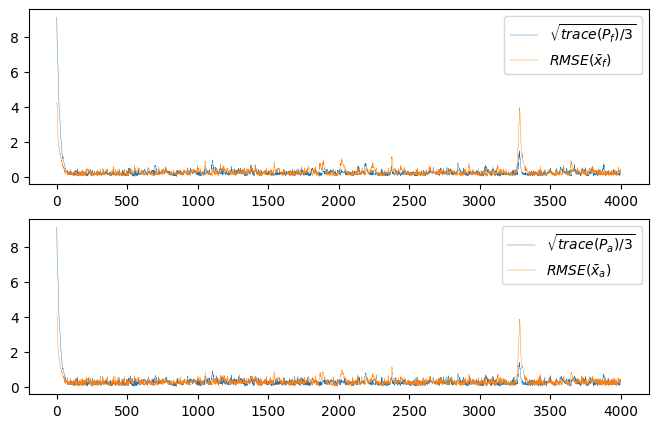

In [225]:
# trace of ensemble covariance of forecast and analysis
trP_f = [np.sqrt(np.trace(P)/3) for P in P_f]
trP_a = [np.sqrt(np.trace(P)/3) for P in P_a]

fig, axes = plt.subplots(2, 1, figsize=(8, 5))
axes[0].plot(trP_f, lw=0.3, label="$ \\sqrt{trace(P_f)/3} $")
axes[0].plot(e_f, lw=0.3, label="$ RMSE(\\bar{x}_f)$")
axes[0].legend()
# axes[0].ylim(0, 2)
axes[1].plot(trP_a, lw=0.3, label="$ \\sqrt{trace(P_a)/3} $")
axes[1].plot(e_a, lw=0.3, label="$ RMSE(\\bar{x}_a)$")
axes[1].legend()